# Q Learning project

Projecto realizado para la asignatura de Inteligencia Artificial de la titulación Grado en Ingeniería Informática - Ingeniería del Software de la Universidad de Sevilla.

## Alumnos

- Muñoz Aranda, Alejandro José <alemunara@alum.us.es>
- Ruano Fernández, Mario <mruano@us.es>

In [49]:
from numpy import *
from random import *
import matplotlib.pyplot as plt

In [50]:
class Board():
    def __init__(self, n, m, initial_state, goal_state):
        self.__n = n
        self.__m = m
        self.__size = n * m
        self.__initial_state = initial_state
        self.__goal_state = goal_state
        self.__map_squares = {}
        self.__map_states = {}
        self.__init_board()
    
    def get_n(self):
        return self.__n
    
    def get_m(self):
        return self.__m

    def get_size(self):
        return self.__size

    def get_map_states(self):
        return self.__map_states
    
    def get_initial_state(self):
        return self.__inital_state
    
    def get_goal_state(self):
        return self.__goal_state

    def __init_board(self):
        states = sample([i for i in range(self.__size)], self.__size)
        k = 0

        for i in range(self.__n):
            for j in range(self.__m):
                state = states[k]
                self.__map_squares[(i, j)] = state
                self.__map_states[state] = (i, j)
                k = k + 1
    
    def is_neighbor(self, square_src, square_dst):
        distance = sqrt(power(square_dst[0] - square_src[0], 2) +
                    power(square_dst[1] - square_src[1], 2))
        return distance <= sqrt(2) and distance > 0

In [54]:
class R():
    def __init__(self, board):
        self.__board = board

    def get_matrix(self):
        size = self.__board.get_size()
        R = zeros(size, size)
        
        for i in range(size):
            for j in range(size):
                if (self.__board.is_neighbor(self.__board.get_map_states()[i], self.__board.get_map_states()[j])):
                    if (j == self.__board.get_goal_state()):
                        R[i, j] = 100
                    else:
                        R[i, j] = 0
                elif (i == self.__board.get_goal_state() and i == j):
                    R[i, j] = 100
                else:
                    R[i, j] = -1
        
        return R

In [55]:
class QLearningAlgorithm():
    def __init__(self, board, R, n_training, gamma):
        self.__board = board
        self.__R = R
        self.__n_training = n_training
        self.__gamma = gamma
        self.__Q = zeros((board.get_size(), board.get_size()))
        
    def get_Q(self):
        return self.__Q
    
    def training(self):
        goal_state = self.__board.get_goal_state()
        performances = []
        for i in range(self.__n_training):
            current_state = choice(list(range(self.__board.get_size())))
            while True:
                possible_actions = {}
                actions = self.__R[current_state]
                for i in range(self.__board.get_size()):
                    if (actions[i] >= 0):
                        possible_actions[i] = actions[i]
                next_state = choice(list(possible_actions.keys()))
                action = next_state
                self.__Q[current_state, action] = self.__R[current_state, action] + self.__gamma * max(self.__Q[next_state])
                current_state = next_state
                if (current_state == goal_state):
                    break
            performances.append(self.__calculate_performance())
        self.__normalize_Q()
        return performances
    
    def __calculate_performance(self):
        performance = 0
        
        for i in range(self.__board.get_size()):
            for j in range(self.__board.get_size()):
                performance = performance + self.__Q[i, j]
                
        max_value = self.__get_max_value()
        
        return (performance / max_value) * 100
    
    def __get_max_value(self):
        values = []
        for i in range(self.__board.get_size()):
            actions = self.__Q[i]
            values.append(max(actions))    
        return max(values)
    
    def __normalize_Q(self):
        max_value = self.__get_max_value()
        
        for i in range(self.__board.get_size()):
            for j in range(self.__board.get_size()):
                self.__Q[i, j] = round((self.__Q[i, j] / max_value) * 100)

In [56]:
board = Board(3,3,1,8)
RMatrix = R(board)
n_training = 2000
agent = QLearningAlgorithm(board, RMatrix.get_matrix(), n_training, 0.8)
performance = agent.training()

TypeError: data type not understood

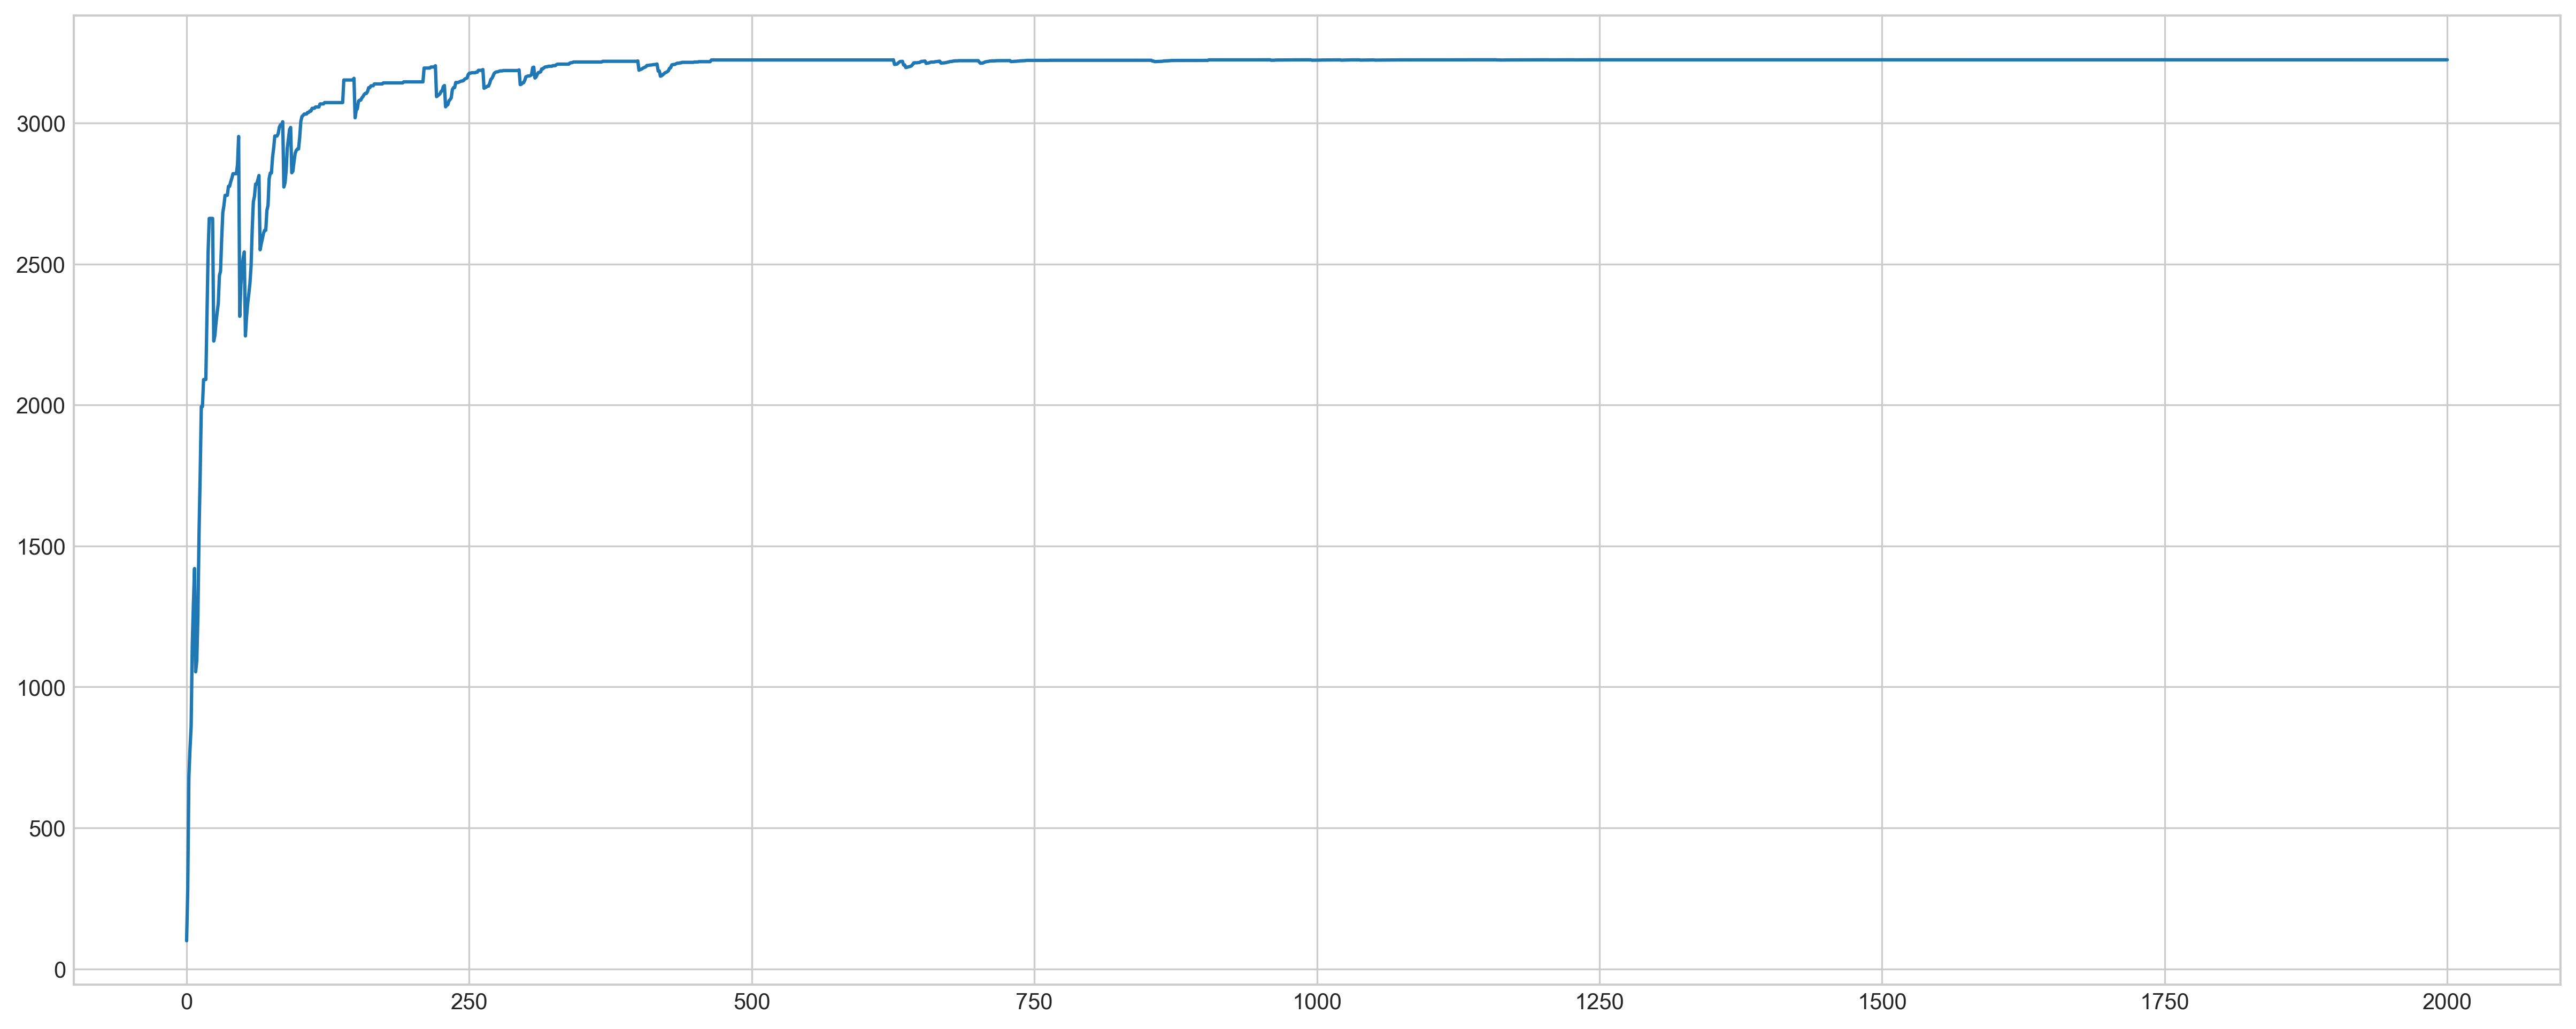

In [16]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,8), dpi=300.)
ax = plt.axes()
x = linspace(0,n_training, n_training)
ax.plot(x, performance)
plt.show()

In [13]:
from tkinter import *
from tkinter import ttk

filas = 0
columnas = 0

def crear_tablero() :
    filas = int(entry1.get())
    columnas = int(entry2.get())    
    
    dimension = (filas*columnas)
    estados = sample([x for x in range(0,dimension)],dimension)
    E = np.zeros((filas,columnas))
    k = 0

    for i in range(0,filas) :
        for j in range(0,columnas) :
            E[i,j] = estados[k]
            k = k + 1    

    return E

root = Tk()
root.title("Q Learning AI")

frame = ttk.Frame(root, padding="50")
frame.grid_propagate(0)
frame.pack(side="top")

label1 = Label(frame, text="Filas del tablero")
label1.pack()
label1.config(justify=CENTER)

entry1 = Entry(frame, width=30)
entry1.pack()

label2 = Label(frame, text="Columnas del tablero")
label2.pack()
label2.config(justify=CENTER)

entry2 = Entry(frame, width=30)
entry2.pack()

label3 = Label(frame, text="Estado inicial")
label3.pack()
label3.config(justify=CENTER)

entry3 = Entry(frame, width=30)
entry3.pack()

label4 = Label(frame, text="Estado objetivo")
label4.pack()
label4.config(justify=CENTER)

entry4 = Entry(frame, width=30)
entry4.pack()

button = Button(frame)
button["text"] = "Obtener tablero"
button["command"] = crear_tablero
button.pack()

root.mainloop()
